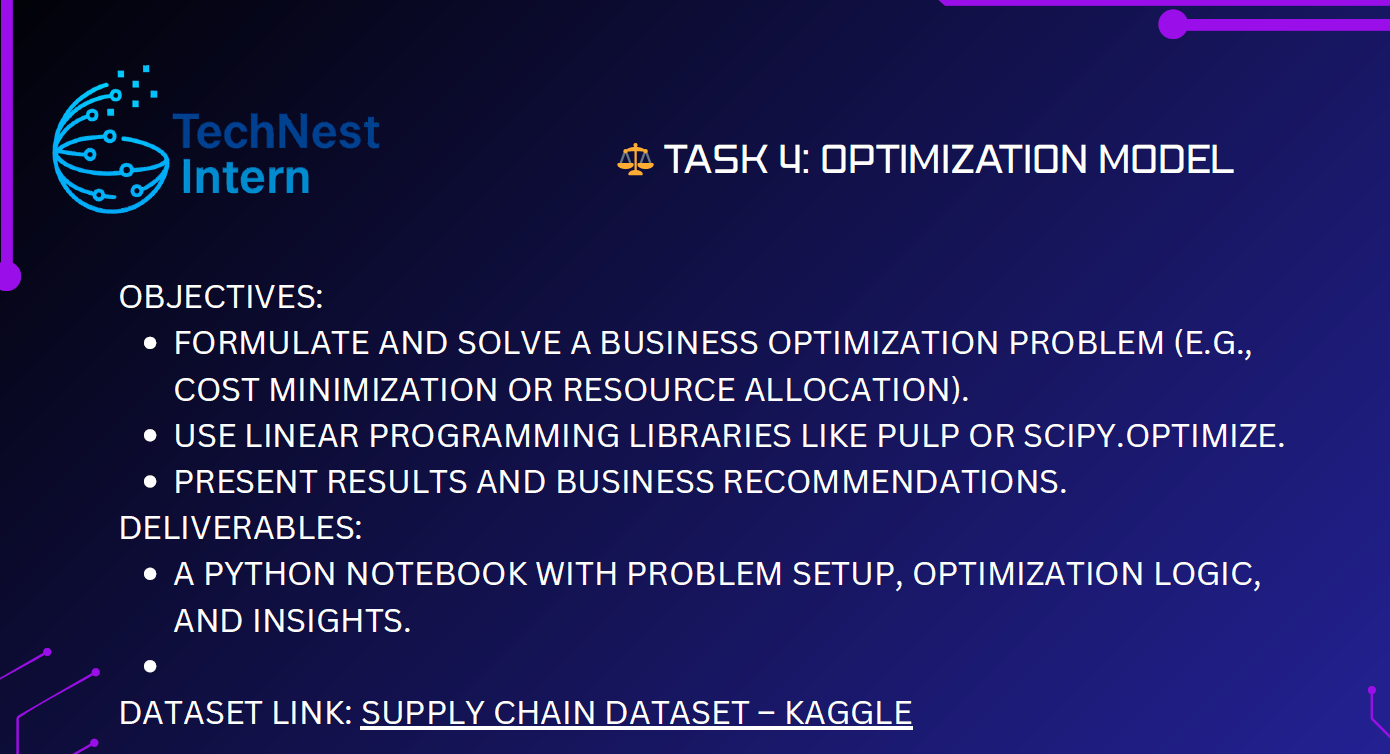

# Importing Libraries Required

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import linprog

# Loading Dataset

In [3]:
data = pd.read_csv('Train.csv')

In [4]:
data.sample(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
4797,4798,B,Flight,6,5,291,4,low,M,9,1413,0
691,692,F,Flight,5,5,140,3,high,F,42,1384,1
9260,9261,A,Ship,3,5,204,2,low,F,1,4025,1
10019,10020,F,Ship,4,4,145,2,medium,M,9,5070,0
8371,8372,F,Flight,5,4,254,3,low,F,4,5611,1
10446,10447,D,Ship,4,5,248,5,low,F,6,1754,0
7034,7035,A,Ship,4,2,257,3,low,M,3,5549,1
9360,9361,D,Ship,7,2,244,4,medium,F,8,1477,1
9323,9324,F,Flight,4,2,262,3,low,M,6,5381,0
1030,1031,C,Ship,4,1,239,2,high,M,16,2504,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


# Supply Chain Cost Minimization using Scipy

**Linear programming (LP)** is a mathematical method used to find the best outcome (like maximum profit or minimum cost) in a system where the relationships between variables are linear. It involves optimizing a linear objective function subject to linear constraints. Essentially, it's a technique for solving optimization problems with limitations expressed as linear equations or inequalities.

Here's a more detailed explanation:

**Objective Function:**
This is the function you want to maximize or minimize (e.g., profit, cost, or resource usage).

**Constraints:**
These are the limitations or restrictions on the variables in the problem, expressed as linear equations or inequalities.

**Linear Relationships:**
Both the objective function and the constraints must be linear, meaning they can be represented by straight lines or planes.

# Builds Cost Vector, Bounds and Constraints

In [25]:
# Cost vectors
costs =  data['Cost_of_the_Product'].values

# warehouses and modes
warehouses = data['Warehouse_block'].unique()
modes = data['Mode_of_Shipment'].unique()

n_routes = len(data)

print(f" Warehouses : {warehouses}")
print(f" Mode of Shipment : {modes}")

# assume each warehouse can ship one at a time
warehouse_capacity = data.groupby('Warehouse_block').size().reindex(warehouses).values

# total demand per mode = count of rows for that mode
mode_demand = data.groupby('Mode_of_Shipment').size().reindex(modes).values

print("Warehouse capacity:", warehouse_capacity)
print("Mode demand:", mode_demand)

 Warehouses : ['D' 'F' 'A' 'B' 'C']
 Mode of Shipment : ['Flight' 'Ship' 'Road']
Warehouse capacity: [1834 3666 1833 1833 1833]
Mode demand: [1777 7462 1760]


# build constraints

SciPy's linprog needs:

Objective: c

Equality: A_eq @ x = b_eq

Inequality: A_ub @ x <= b_ub

Bounds for variables

In [26]:
# Capacity Constraints
A_ub = np.zeros((len(warehouses),n_routes))

for i,w in enumerate(warehouses):
  A_ub[i, data['Warehouse_block']==w] = 1
b_ub = warehouse_capacity

# Demand constraints

A_eq = np.zeros((len(modes),n_routes))

for i,m in enumerate(modes):
  A_eq[i, data['Mode_of_Shipment']==m] = 1
b_eq = mode_demand

# Bounds : each shipment >= 0
bounds = [(0,1)] * n_routes

# Solving using Scipy Linear Programming

In [27]:
results = linprog(
    c = costs,
    A_ub = A_ub,
    b_ub = b_ub,
    A_eq = A_eq,
    b_eq = b_eq,
    bounds = bounds,
    method = 'highs'
)

print("Status:", results.message)
print("Optimal total shipping cost:", results.fun)

Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal total shipping cost: 2311955.0


# Showing Shipping Plan

In [29]:
data['ShipQty'] = results.x

print("\nOptimal shipping plan (non-zero only):")
data[data['ShipQty'] > 0]


Optimal shipping plan (non-zero only):


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,ShipQty
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,1.0
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,1.0
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,1.0
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,1.0
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1,1.0
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0,1.0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0,1.0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0,1.0


# **Business Recommendations**

## Business Insights

1. Minimum total shipping cost for current plan: **2311955.0**

2. This plan uses warehouse capacities efficiently:

- Each warehouse does not exceed its limit.

- Each shipping mode gets the required shipments.

3. Use actual shipping costs instead of product cost for more realistic optimization.  

Also, analyze `Reached.on.Time_Y.N` to adjust future mode choices for reliability.